In [30]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy import ndimage

1. Подберите парамтеры алгоритма разрастания регионов так, чтобы был выделен весь участок газона.

In [31]:
image = cv2.imread('sar_1 (1).jpg')
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [32]:
def homo_average(img, mask, point, T):
    masked_region = img[mask > 0]
    if len(masked_region) == 0:
        return False
    av_val = masked_region.mean()
    
    if abs(av_val - img[point]) <= T:
        return True
    
    return False

In [33]:
def region_growing(image, seed_point, homo_fun, r, T):
    mask = np.zeros(image.shape, np.uint8)
    mask[seed_point] = 1  
    count = 1
    while count > 0:
        count = 0
        local_mask = np.zeros(image.shape, np.uint8)
        for i in range(r, image.shape[0] - r):
            for j in range(r, image.shape[1] - r):
                if mask[i, j] == 0 and mask[i - r:i + r, j - r:j + r].sum() > 0:
                    if homo_fun(image, mask, (i, j), T):
                        local_mask[i, j] = 1
        count = np.count_nonzero(local_mask)
        mask += local_mask
    return mask * 255

In [34]:
seed_point = (250, 250)  
r = 4  
T = 18  

In [35]:
res = region_growing(image_gray, seed_point, homo_average, r, T)

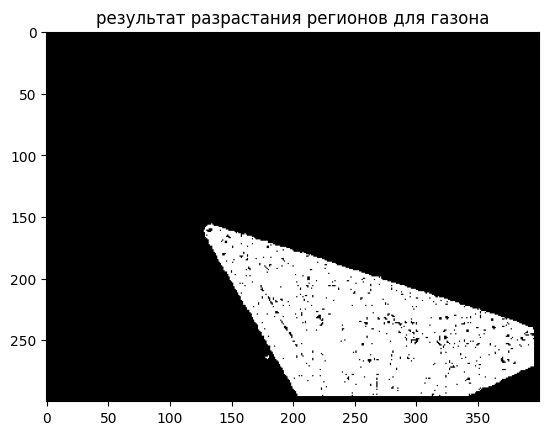

In [36]:
plt.imshow(res, cmap="gray")
plt.title("результат разрастания регионов для газона")
plt.show()

2. Реализуйте вычисление критерия однородности, отличного от представленного. Сравните результаты.

In [37]:
def homo_median(img, mask, point, T):
    masked_region = img[mask > 0]
    if len(masked_region) == 0:
        return False
    median_val = np.median(masked_region)
    
    if abs(median_val - img[point]) <= T:
        return True
    
    return False

In [38]:
mask_average = region_growing(image_gray, seed_point, homo_average, 4, 25)
mask_median = region_growing(image_gray, seed_point, homo_median, 4, 25)

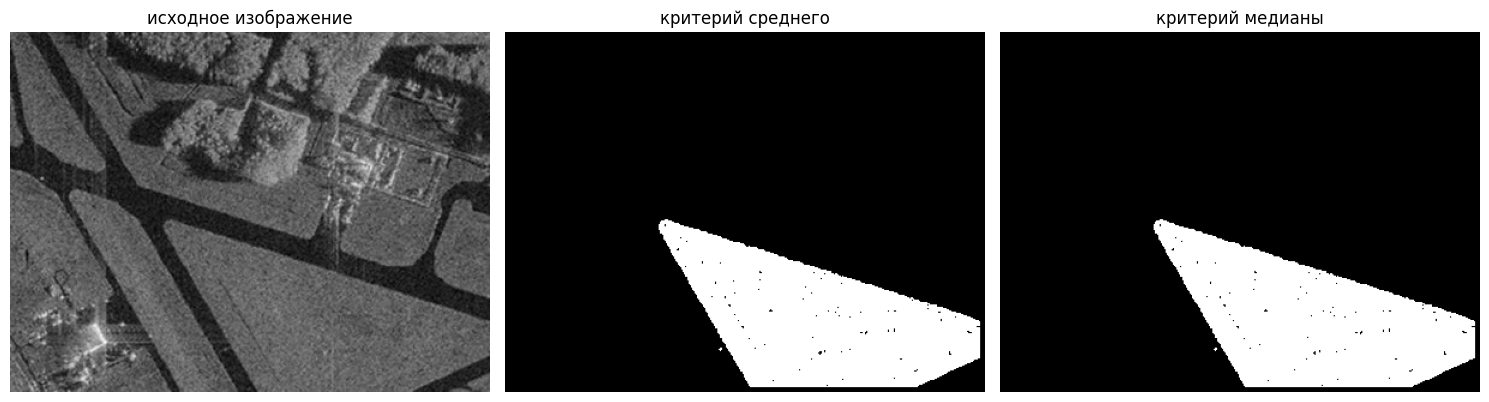

площадь (среднее): 20771
площадь (медиана): 20775


In [39]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(image_gray, cmap='gray')
axes[0].set_title('исходное изображение')
axes[0].axis('off')

axes[1].imshow(mask_average, cmap='gray')
axes[1].set_title('критерий среднего')
axes[1].axis('off')

axes[2].imshow(mask_median, cmap='gray')
axes[2].set_title('критерий медианы')
axes[2].axis('off')

plt.tight_layout()
plt.show()

print(f"площадь (среднее): {np.count_nonzero(mask_average)}")
print(f"площадь (медиана): {np.count_nonzero(mask_median)}")

3. Применить алгоритм сегментации watershed+distance transform для задачи подсчета пальмовых деревьев.

In [40]:
def apply_kmeans(image, K):
    z = image.reshape((-1, 1))  
    z = np.float32(z)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    ret, label, center = cv2.kmeans(z, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    center = np.uint8(center)
    res = center[label.flatten()]
    res2 = res.reshape((image.shape))
    return res2

k2_result = apply_kmeans(image_gray, 2)
k3_result = apply_kmeans(image_gray, 3)
k4_result = apply_kmeans(image_gray, 4)


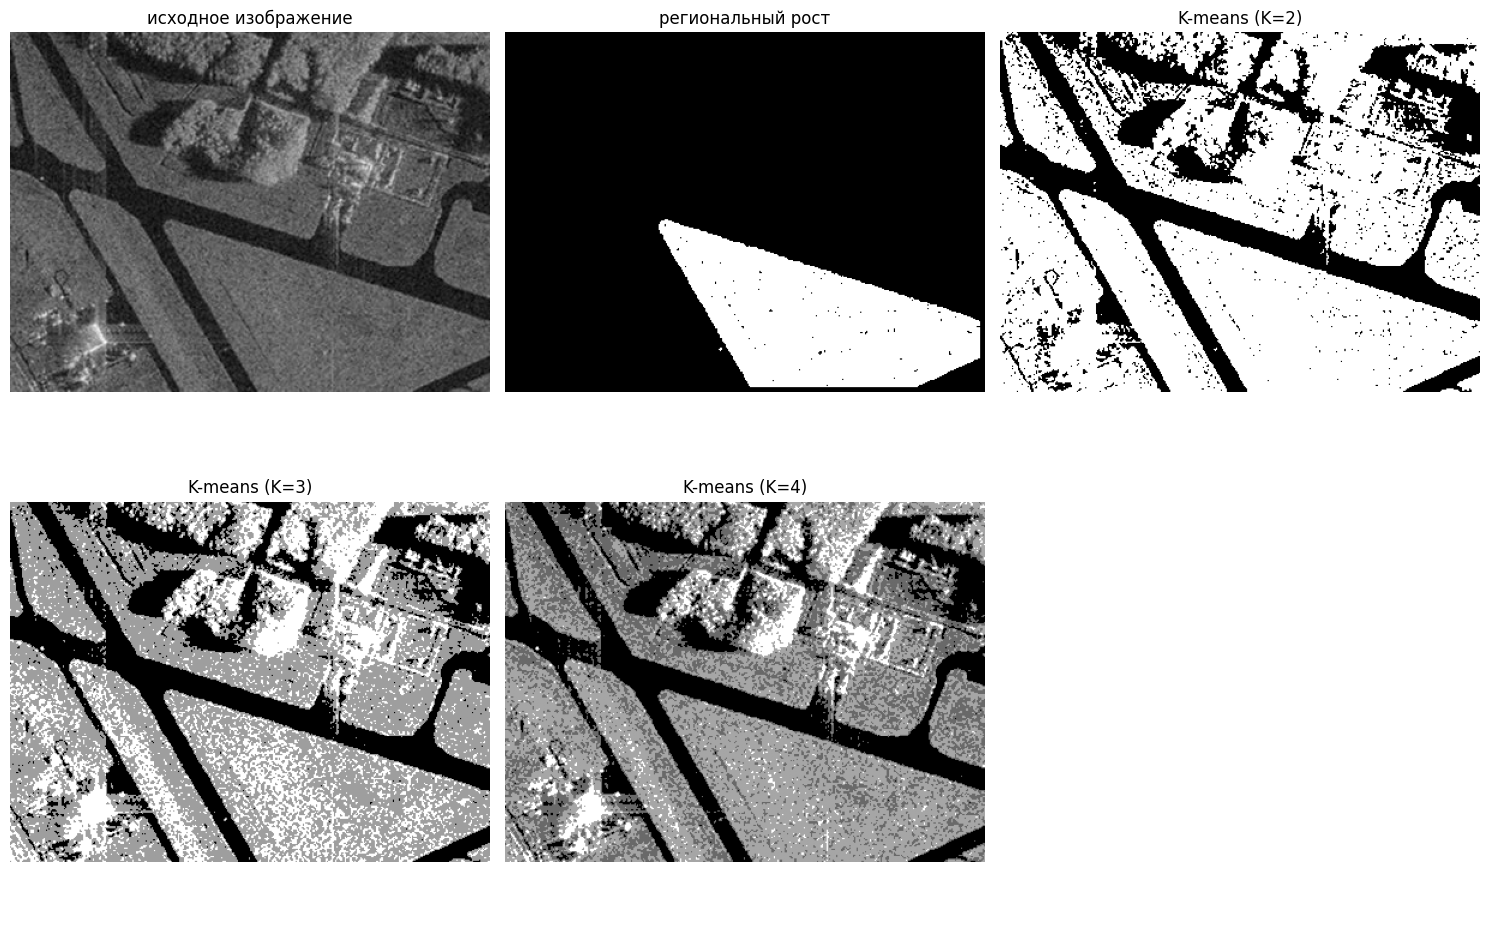

In [41]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

axes[0, 0].imshow(image_gray, cmap='gray')
axes[0, 0].set_title('исходное изображение')
axes[0, 0].axis('off')

axes[0, 1].imshow(mask_average, cmap='gray')
axes[0, 1].set_title('региональный рост')
axes[0, 1].axis('off')

axes[0, 2].imshow(k2_result, cmap='gray')
axes[0, 2].set_title('K-means (K=2)')
axes[0, 2].axis('off')

axes[1, 0].imshow(k3_result, cmap='gray')
axes[1, 0].set_title('K-means (K=3)')
axes[1, 0].axis('off')

axes[1, 1].imshow(k4_result, cmap='gray')
axes[1, 1].set_title('K-means (K=4)')
axes[1, 1].axis('off')

axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

watershed + distance

In [42]:
image = cv2.imread("palm_1.JPG")
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(15, 10))

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

Text(0.5, 1.0, 'бинаризация')

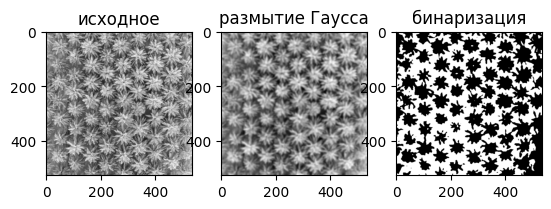

In [43]:
blurred = cv2.GaussianBlur(image_gray, (13, 13), 0)
ret, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

plt.subplot(2, 3, 1)
plt.imshow(image_gray, cmap='gray')
plt.title('исходное')

plt.subplot(2, 3, 2)
plt.imshow(blurred, cmap='gray')
plt.title('размытие Гаусса')

plt.subplot(2, 3, 3)
plt.imshow(thresh, cmap='gray')
plt.title('бинаризация')

In [44]:
dist_transform = cv2.distanceTransform(thresh, cv2.DIST_L2, 5)

Text(0.5, 1.0, 'Distance Transform')

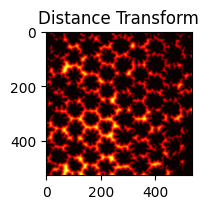

In [45]:
local_maxima = ndimage.maximum_filter(dist_transform, size=20, mode='constant')

plt.subplot(2, 3, 4)
plt.imshow(dist_transform, cmap='hot')
plt.title('Distance Transform')

Text(0.5, 1.0, 'маркеры перед Watershed')

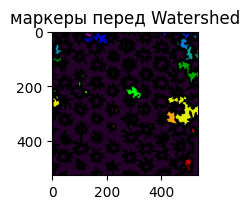

In [46]:
ret, sure_fg = cv2.threshold(dist_transform, 0.1 * dist_transform.max(), 255, cv2.THRESH_BINARY)
sure_fg = sure_fg.astype(np.uint8)

ret, markers = cv2.connectedComponents(sure_fg)
markers[dist_transform == local_maxima] = 1

plt.subplot(2, 3, 5)
plt.imshow(markers, cmap='nipy_spectral')
plt.title('маркеры перед Watershed')

In [47]:
markers = ndimage.label(markers)[0]  
markers = cv2.watershed(image, markers.astype(np.int32))

In [48]:
num_trees = len(np.unique(markers)) - 1

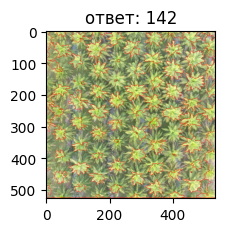

количество пальмовых деревьев: 142


In [49]:
segmented_image = image.copy()
segmented_image[markers == -1] = [0, 0, 255]  # Границы сегментов

plt.subplot(2, 3, 6)
plt.imshow(cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB))
plt.title(f'ответ: {num_trees}')

plt.tight_layout()
plt.show()

print(f"количество пальмовых деревьев: {num_trees}")